In [1]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from scipy.optimize import minimize, Bounds

In [2]:
points = np.random.random((2, 2))
ones_x = np.zeros_like(points)
ones_x[:, 0] = 1
ones_y = np.zeros_like(points)
ones_y[:, 1] = 1

def expand_point(point):
    stack = np.zeros((9, 2))
    idx = 0
    for i in [0, -1, 1]:
        for j in [0, -1, 1]:
            stack[idx, :] = point + [i, j]
            idx += 1
    return stack

expanded_points = np.vstack([expand_point(point) for point in points])
m = len(expanded_points)

In [3]:
def plot_grid(players, ax=False):
    N = len(players)
    colours = np.arange(9 * N) // 9
    norm = mpl.colors.Normalize(vmin=0, vmax=N, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Pastel1)

    players_ext = np.vstack([expand_point(player) for player in players])
    vor = Voronoi(players_ext)

    if ax:
        fig = voronoi_plot_2d(vor, ax=ax)
        ax.plot([0, 0, 1, 1, 0], [0, 1, 1, 0, 0], color="black",linestyle="--")
        ax.scatter(*players[0,:], color="red")

        for idx, r in enumerate(vor.point_region):
            region = vor.regions[vor.point_region[idx]]
            if not -1 in region:
                ax.fill(*zip(*vor.vertices[region]), color=mapper.to_rgba(colours[idx]))

        ax.set_xlim(-0.5,1.5)
        ax.set_ylim(-0.5,1.5)
        ax.set_aspect("equal")

    else:
        fig = voronoi_plot_2d(vor)
        plt.plot([0, 0, 1, 1, 0], [0, 1, 1, 0, 0], color="black",linestyle="--")
        plt.scatter(*players[0,:], color="red")

        for idx, r in enumerate(vor.point_region):
            region = vor.regions[vor.point_region[idx]]
            if not -1 in region:
                plt.fill(*zip(*vor.vertices[region]), color=mapper.to_rgba(colours[idx]))
        
        plt.xlim(-0.5, 1.5)
        plt.ylim(-0.5, 1.5)
        plt.gca().set_aspect("equal")

In [4]:
def payoff(x, players):
    others = np.vstack([expand_point(player) for player in players])
    game_points = np.vstack([expand_point(x), others])
    game_zones = Voronoi(game_points)
    payoff = ConvexHull(game_zones.vertices[game_zones.regions[game_zones.point_region[0]]]).volume
    return payoff
    

def get_max(players):
    # Bounding box (0, 1), (0, 1)
    bounds = Bounds([0, 0], [1, 1])
    f = lambda x: -payoff(x, players)
    x0 = np.array([0.5, 0.5])
    res = minimize(f, x0, method='trust-constr', bounds=bounds)
    return res.x, -res.fun

In [5]:
def eqm(x0, tol=1e-4, max_iter=100, 
        print_graphs=False,
        record_paths=False,
        momentum=False):
    if print_graphs:
        max_iter = print_graphs
        fig, axs = plt.subplots(max_iter // 5, 5,
                                figsize=(20, 4 * (max_iter // 5)), layout="tight")

    x = x0.copy()
    N = len(x0)
    
    if record_paths:
        path_list = np.empty((max_iter + 1, N, 2))
        path_list[0] = x0

    x_prev = np.ones_like(x0) * 100
    iters = 0
    NC = False
    while np.linalg.norm(x - x_prev) > tol and iters < max_iter:
        x_prev = x.copy()
        for idx, player in enumerate(x):
            others = np.delete(x, idx, axis=0)
            old_PO = payoff(player, others)
            new_point, new_PO = get_max(others)
            if not np.isclose(old_PO, new_PO):
                if momentum:
                    x[idx] += momentum * (new_point - x[idx])
                else:
                    x[idx] = new_point
        if print_graphs:
            plot_grid(x, ax=axs[iters // 5][iters % 5])
        if record_paths:
            path_list[iters + 1] = x.copy()
        iters += 1
        if iters >= max_iter:
            print(f"{x} gave non-convergent payoffs")
            NC = True
    if record_paths:
        return x, x0, NC, path_list
    else:
        return x, x0, NC

In [321]:
# 3 Test:
N = 10
payoff_3 = np.zeros((N, 3))
players_3 = np.zeros((N, 3, 2))
nc_dict = {}
for i in range(N):
    eqm_players, x0, NC = eqm(np.random.random((3, 2)))
    if NC:
        nc_dict[i] = [x0, eqm_players]
    players_3[i] = eqm_players
    for idx, player in enumerate(eqm_players):
        others = np.delete(eqm_players, idx, axis=0)
        payoff_x = payoff(player, others)
        payoff_3[i, idx] = payoff_x
    
    payoff_3[i, :] = np.sort(payoff_3[i, :])
    print(f"Iter {i}'s payoffs: {payoff_3[i, :]}")

c:\Users\jacki\OneDrive\Documents\ScientificComputationLabs\SC_venve\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Iter 0's payoffs: [0.32502766 0.32937621 0.34559613]
Iter 1's payoffs: [0.2133267  0.32829919 0.4583741 ]
Iter 2's payoffs: [0.33255502 0.33372179 0.33372319]
[[0.40237579 0.38209836]
 [0.6389401  0.36690924]
 [0.35046786 0.86505951]] gave non-convergent payoffs
Iter 3's payoffs: [0.23900289 0.35145098 0.40954613]
[[0.28256566 0.27734546]
 [0.79691464 0.52331253]
 [0.79542825 0.77729494]] gave non-convergent payoffs
Iter 4's payoffs: [0.24997218 0.34483069 0.40519713]
Iter 5's payoffs: [0.32136629 0.33204795 0.34658576]
Iter 6's payoffs: [0.32371995 0.33072665 0.3455534 ]
Iter 7's payoffs: [0.2125985  0.32830686 0.45909464]
Iter 8's payoffs: [0.32424127 0.32979525 0.34596348]
Iter 9's payoffs: [0.33249078 0.33375461 0.33375461]


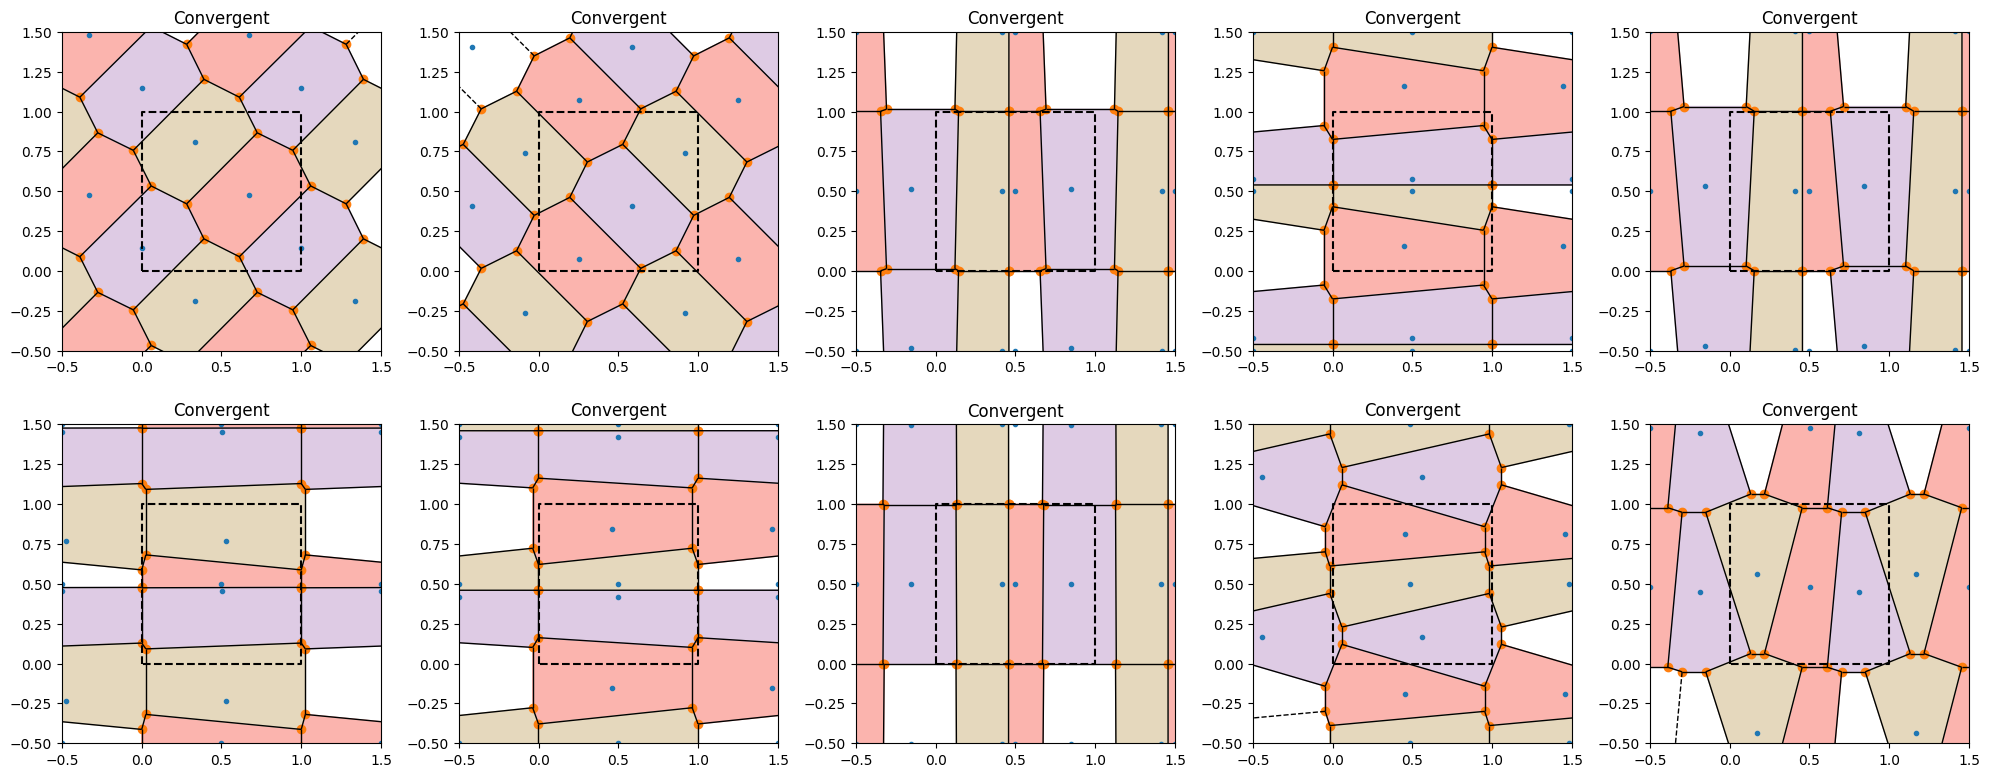

In [11]:
fig, axs = plt.subplots(N // 5, 5,
                        figsize=(20, 4 * (N // 5)), layout="tight")
for idx, player in enumerate(players_3):
    if idx in nc_dict.keys():
        axs[idx // 5][idx % 5].set_title("Non-Convergent")
    else:
        axs[idx // 5][idx % 5].set_title("Convergent")
    plot_grid(player, ax=axs[idx // 5][idx % 5])

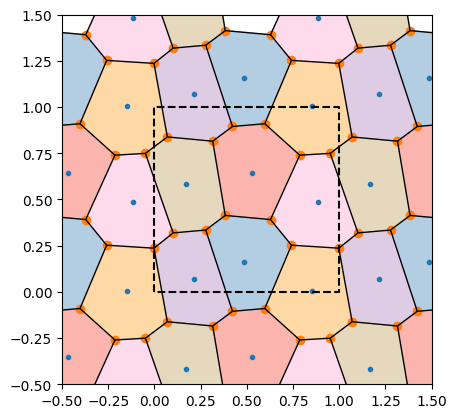

In [16]:
np.random.seed(2)
nc_players = [np.random.random((6, 2))]
nc_players_eqm, x0, NC, paths = eqm(nc_players[0],
                                max_iter=100,
                                record_paths=True,
                                momentum=False)
plot_grid(nc_players_eqm)

In [ ]:
# nc_players = nc_dict[2]
fig, axs = plt.subplots(1, 4, figsize=(32, 8), layout="tight")
for idx, N_ in enumerate([4, 4, 5, 6]):
    if idx == 1:
        np.random.seed(3)
    else:
        np.random.seed(2)
    nc_players = [np.random.random((N_, 2))]
    nc_players_eqm, x0, NC, paths = eqm(nc_players[0],
                                    max_iter=100,
                                    record_paths=True,
                                    momentum=False) 
    axs[idx].set_title(f"PNE for {N_} Players")

    plot_grid(nc_players_eqm, ax=axs[idx])
    print(f"player {N_} done.")



player 4 done.
player 4 done.


TypeError: remove: path should be string, bytes or os.PathLike, not NoneType

: 

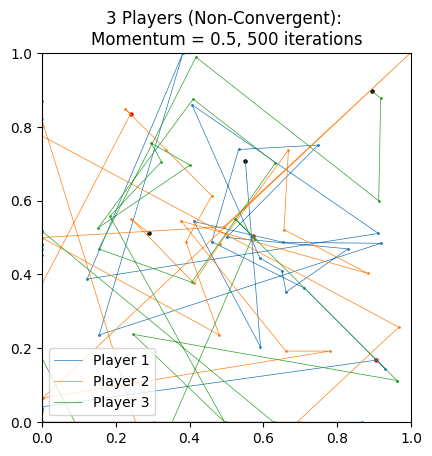

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
for idx, pl in enumerate(paths.transpose(1, 0, 2)):
    pl = pl[np.linalg.norm(pl, axis=1) > 1e-10]
    ax.plot(*pl.T, linewidth=0.5, label=f"Player {idx+1}")
    ax.scatter(*pl.T, s=1)

ax.set_title("3 Players (Non-Convergent): \nMomentum = 0.5, 500 iterations")
ax.scatter(*nc_players[0].T, s=5, color="black")
ax.scatter(*nc_players_eqm.T, s=5, color="red")
ax.legend();

In [14]:
def manual_check(players, grain=100):
    max_pay = 0
    max_point = np.zeros((1, 2))
    xvals = np.linspace(0, 1, grain)
    yvals = np.linspace(0, 1, grain)
    xgrid, ygrid = np.meshgrid(xvals, yvals)
    xgrid = xgrid.flatten()
    ygrid = ygrid.flatten()
    for a, b in zip(xgrid, ygrid):
        test_point = np.array([[a, b]])
        test_payoff = payoff(test_point, players)
        if max_pay < test_payoff:
            max_pay = test_payoff
            max_point = test_point
    return max_point, max_pay

In [14]:
def full_plot(players, man_check=False):
    # players = np.vstack([expand_point(player) for player in players])

    for idx, player in enumerate(players):
        others = np.delete(players, idx, axis=0)
        payoff_x = payoff(player, others)
        print(f"Player {idx + 1} Payoff: {payoff_x}")
        
        if man_check:
            man_max_point, man_max = manual_check(others, grain=50) 
            print(f"Max payoff: {man_max} at {man_max_point}")
    
    plot_grid(players)

Player 1 Payoff: 0.15625000000000006
Player 2 Payoff: 0.3606150793650793
Player 3 Payoff: 0.3479662698412698
Player 4 Payoff: 0.13516865079365067
Player 1 Payoff: 0.15625
Player 2 Payoff: 0.3479662698412698
Player 3 Payoff: 0.36061507936507936
Player 4 Payoff: 0.13516865079365079
Player 1 Payoff: 0.15625
Player 2 Payoff: 0.3479662698412698
Player 3 Payoff: 0.36061507936507925
Player 4 Payoff: 0.13516865079365076
Player 1 Payoff: 0.15625
Player 2 Payoff: 0.36061507936507936
Player 3 Payoff: 0.3479662698412699
Player 4 Payoff: 0.13516865079365076
Player 1 Payoff: 0.15625000000000003
Player 2 Payoff: 0.3479662698412699
Player 3 Payoff: 0.3606150793650793
Player 4 Payoff: 0.13516865079365087
Player 1 Payoff: 0.15625
Player 2 Payoff: 0.3606150793650794
Player 3 Payoff: 0.3479662698412698
Player 4 Payoff: 0.13516865079365076
Player 1 Payoff: 0.15625
Player 2 Payoff: 0.3479662698412699
Player 3 Payoff: 0.36061507936507936
Player 4 Payoff: 0.13516865079365076
Player 1 Payoff: 0.242360491071428

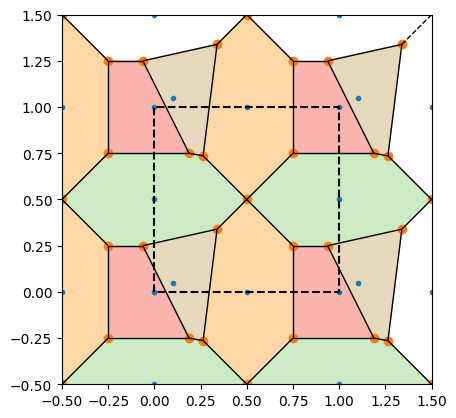

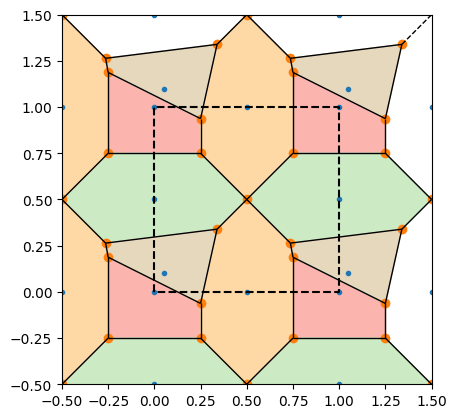

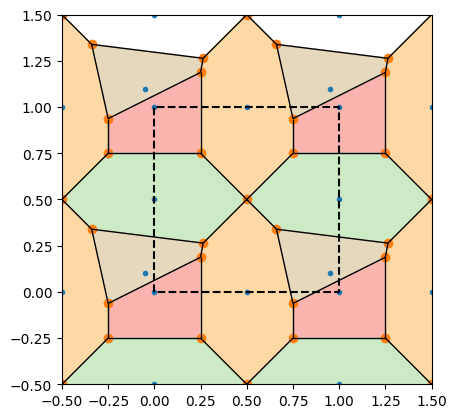

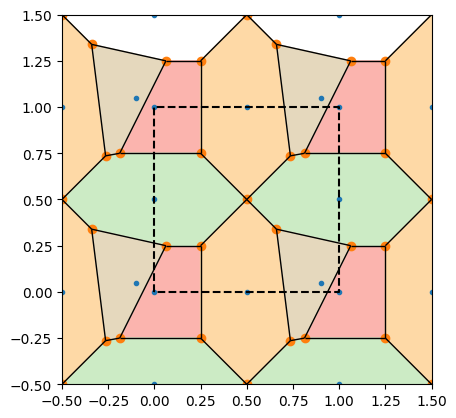

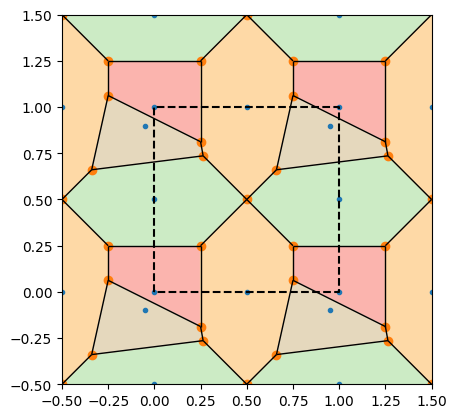

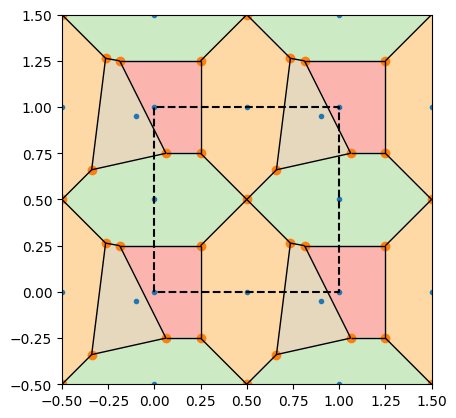

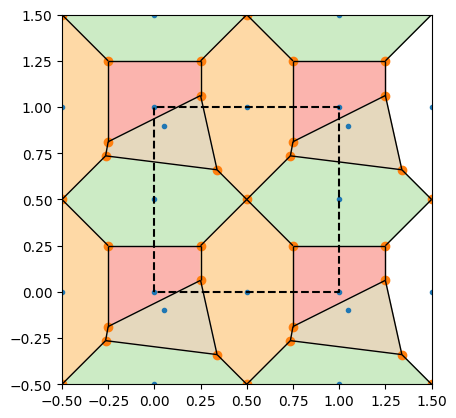

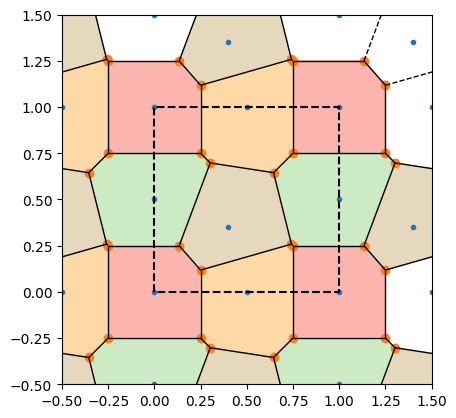

In [ ]:
np.random.seed(3)
r_point = 0.5 * np.random.random((1, 2))
c_point = np.array([[0.5, 0.5]])
r_vec = np.random.random((1, 2))
r_vec = 0.5 / np.linalg.norm(r_vec) * r_vec
r_point = np.array([[0,0]])
p4_s = np.vstack([r_point,
                  r_point + [0, 0.5],
                  r_point + [0.5, 0],
                  r_point + [0.1, 0.05]])

eqm_players_4, x0, NC = eqm(p4_s)

p3_s = np.vstack([c_point, c_point + r_vec, c_point - r_vec])
# eqm_players_3, x0, NC = eqm(p3_s)

# eqm_players, x0, NC = eqm(np.random.random((5, 2)))

full_plot(p4_s)

p4_s = np.vstack([r_point,
                  r_point + [0, 0.5],
                  r_point + [0.5, 0],
                  r_point + [0.4, 0.35]])

full_plot(p4_s)


# full_plot(eqm_players_4)
# plt.scatter(*p4_s.T, s=20, color="black")

In [256]:
def payoff_1d(x):
    payoffs = np.zeros_like(x)
    if x[0] == x[1] and x[1] == x[2]:
        payoffs =  np.ones_like(x) / 3
    elif x[0] == x[1]:
        payoffs[0] = (x[0] + x[2]) / 4
        payoffs[1] = (x[0] + x[2]) / 4
        payoffs[2] = 1 - 2 * payoffs[0]
    elif x[1] == x[2]:
        payoffs[0] = (x[0] + x[1]) / 2
        payoffs[1] = (1 - payoffs[0]) / 2
        payoffs[2] = payoffs[1]
    else:
        payoffs[0] = (x[0] + x[1]) / 2
        payoffs[1] = (x[2] - x[0]) / 2
        payoffs[2] = 1 - payoffs[0] - payoffs[1]
    return payoffs


In [299]:
N = 10
locs = np.linspace(0, 1, N)
idx = 0
payoff_ordered = np.zeros((N * (N + 1) * (N + 2) // 6,3))
for i, loc_i in enumerate(locs):
    for j, loc_j in enumerate(locs[i:]):
        for k, loc_k in enumerate(locs[i+j:]):
            x_ = np.array([loc_i, loc_j, loc_k])
            payoff_ordered[idx] = payoff_1d(x_)
            idx += 1


In [306]:
def get_idx(i,j,k):
    i_part = (i * (i ** 2 - 3 * (N + 1) * i + 3 * N ** 2 + 6 * N + 2)) // 6
    j_part = (j - i) * (2 * N + 1 - i - j) // 2
    k_part = k - j
    return i_part + j_part + k_part

In [310]:
def payoff_1d_fast(x):
    args = np.argsort(x, axis=1)
    sorted_x = np.sort(x, axis=1)
    ordered_p = payoff_ordered[get_idx(*sorted_x.T)]
    return ordered_p[args == 0]

def po_pure_mix(a, bm, cm):
    full_pos = np.arange(N)
    b_mesh, c_mesh = np.meshgrid(bm, cm)
    b_full, c_full = np.meshgrid(full_pos, full_pos)
    to_payoff = np.hstack([a * np.ones_like(b_full.flatten()[:,None]), b_full.flatten()[:,None], c_full.flatten()[:,None]])
    weights = b_mesh.flatten() * c_mesh.flatten()
    payoff_vec = payoff_1d_fast(to_payoff)
    return np.sum(payoff_vec * weights)


In [311]:
def f(X_mat):
    A = np.zeros(N)
    B = np.zeros(N)
    C = np.zeros(N)
    for x in range(N):
        A[x] = po_pure_mix(x, X_mat[1], X_mat[2])
        B[x] = po_pure_mix(x, X_mat[0], X_mat[2])
        C[x] = po_pure_mix(x, X_mat[0], X_mat[1])
    A = np.maximum(0, A - np.sum(X_mat[0] * A))
    B = np.maximum(0, A - np.sum(X_mat[0] * A))
    C = np.maximum(0, A - np.sum(X_mat[0] * A))

    X_mat[0] = (X_mat[0] + A) / (1 + A.sum())
    X_mat[1] = (X_mat[1] + B) / (1 + B.sum())
    X_mat[2] = (X_mat[2] + C) / (1 + C.sum())

    return X_mat


In [315]:
mixed_strats = np.ones((3,N)) / N
mixed_strats = np.array([[0.1, 0.2, 0.1, 0, 0, 0.2, 0.1, 0.1, 0.1, 0.1 ], 
             [0.1, 0.1, 0.2, 0.1, 0.1, 0.2, 0, 0, 0.1, 0.1 ], 
             [0, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0.1, 0.2 ]])
old_strats = np.zeros((3,N))

tol = 1e-5
itera = 0
while np.linalg.norm(mixed_strats - old_strats) > tol:
    old_strats = mixed_strats.copy()
    mixed_strats = f(mixed_strats)
    print(f"Iteration: {itera}, diff = {np.linalg.norm(mixed_strats - old_strats)}")
    itera += 1


Iteration: 0, diff = 0.17670184473867165
Iteration: 1, diff = 0.08652721198939631
Iteration: 2, diff = 0.05630852623305461
Iteration: 3, diff = 0.04257027441706475
Iteration: 4, diff = 0.03269486669544009
Iteration: 5, diff = 0.025844858193491183
Iteration: 6, diff = 0.021115076259767045
Iteration: 7, diff = 0.017662213533645357
Iteration: 8, diff = 0.015035012250198593
Iteration: 9, diff = 0.012973341632102847
Iteration: 10, diff = 0.01131763603876097
Iteration: 11, diff = 0.009964549379631992
Iteration: 12, diff = 0.008843862439057841
Iteration: 13, diff = 0.00790584419078527
Iteration: 14, diff = 0.007114023910655661
Iteration: 15, diff = 0.006440881652385294
Iteration: 16, diff = 0.005865170851912072
Iteration: 17, diff = 0.0053701859612877234
Iteration: 18, diff = 0.004942597080162459
Iteration: 19, diff = 0.004571637777823934
Iteration: 20, diff = 0.0042485216774332925
Iteration: 21, diff = 0.003966013041532973
Iteration: 22, diff = 0.003718104768359652
Iteration: 23, diff = 0.00

(0.0, 1.0)

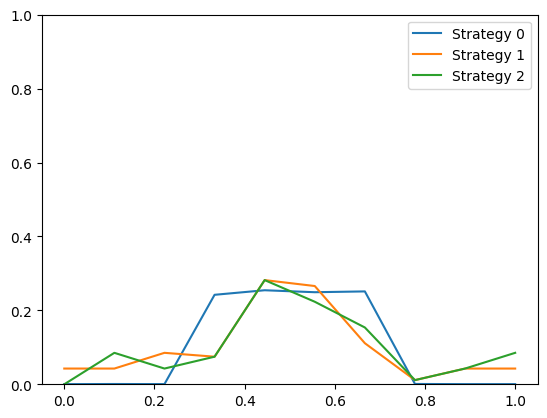

In [316]:
fig, ax = plt.subplots()
for idx, strat in enumerate(mixed_strats):
    ax.plot(locs, strat, label=f"Strategy {idx}")
ax.legend()
ax.set_ylim(0, 1)